In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import random

from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.python.keras import utils

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime

from openpyxl import Workbook
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

import os.path

import multiprocessing
import os
import time

# UCI Breast Cancer Data (Original)
- https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original

In [ ]:
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', na_values='?',
                   header=None, index_col=['ID'], names = headers)
data.isna().any()

CT           False
UCSize       False
UCShape      False
MA           False
SECSize      False
BN            True
BC           False
NN           False
Mitoses      False
Diagnosis    False
dtype: bool

In [ ]:
data = data.reset_index(drop=True)
data

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2.0,1,1,1,2
695,2,1,1,1,2,1.0,1,1,1,2
696,5,10,10,3,7,3.0,8,10,2,4
697,4,8,6,4,3,4.0,10,6,1,4


In [ ]:
data1 = data.copy()
y = data1['Diagnosis'] # labels
X = data1.drop(['Diagnosis'], axis = 1)
print(X)
print(y)
print(y.value_counts())

     CT  UCSize  UCShape  MA  SECSize    BN  BC  NN  Mitoses
0     5       1        1   1        2   1.0   3   1        1
1     5       4        4   5        7  10.0   3   2        1
2     3       1        1   1        2   2.0   3   1        1
3     6       8        8   1        3   4.0   3   7        1
4     4       1        1   3        2   1.0   3   1        1
..   ..     ...      ...  ..      ...   ...  ..  ..      ...
694   3       1        1   1        3   2.0   1   1        1
695   2       1        1   1        2   1.0   1   1        1
696   5      10       10   3        7   3.0   8  10        2
697   4       8        6   4        3   4.0  10   6        1
698   4       8        8   5        4   5.0  10   4        1

[699 rows x 9 columns]
0      2
1      2
2      2
3      2
4      2
      ..
694    2
695    2
696    4
697    4
698    4
Name: Diagnosis, Length: 699, dtype: int64
Diagnosis
2    458
4    241
Name: count, dtype: int64


In [ ]:
y.replace({2: 0, 4: 1}, inplace=True)
print(y)
print(y.value_counts())

0      0
1      0
2      0
3      0
4      0
      ..
694    0
695    0
696    1
697    1
698    1
Name: Diagnosis, Length: 699, dtype: int64
Diagnosis
0    458
1    241
Name: count, dtype: int64


In [ ]:
UCI_X = X
UCI_y = y

In [ ]:
# Dataset Setting
file_name = './Breast_cancer.xlsx'
excel_sheet_name = 'breast_cancer'
value = "number_of_neuron"
number_of_NNs = 20

In [ ]:
if os.path.isfile(file_name):
    wb = load_workbook(file_name, read_only=True)   # open an Excel file and return a workbook
    if excel_sheet_name in wb.sheetnames:
        print('sheet exist:',excel_sheet_name)
        number_of_index_done = pd.read_excel(file_name,sheet_name=excel_sheet_name,header=None)
        #print(number_of_index_done)

        if len(number_of_index_done) == 0:
            starting = len(number_of_index_done)
            print("Starting index:",starting) #when the excel file is empty

        else:
            if len(number_of_index_done) == len(UCI_X):
                print('Done')
                starting = None

            else:
                starting = number_of_index_done[0].iloc[-1]+1
                print("Starting index:",starting) #Still need to generate index
    else:
        print("no sheet exist, generate")
        wb = load_workbook(file_name)
        wb.create_sheet(excel_sheet_name)
        wb.save(file_name)
        starting = 0

else:
    print("no file exist, generate")
    wb = Workbook()
    ws = wb.active
    ws.title = excel_sheet_name
    wb.save(filename = file_name)
    starting = 0

sheet exist: breast_cancer
Starting index: 0


## Set: CDmc process (number of neuron in hidden layer = 1)

In [ ]:
# manually generate the different random seed
def random_generater():
    return(random.randint(1, 100000))

def nn_model_complexity_multiprocessing(X, y, X_test, y_test,number_of_neuron):
    count = 0
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=random_generater())

    #Missing data imputatoin
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(number_of_neuron, input_shape=(X_train_scaled.shape[1],), activation='relu')) #Increasing number of neuron
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #output layer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                        batch_size=32, epochs=100, verbose=0, callbacks=[es])

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

    if y_pred == y_test:
        count += 1
    else:
        count +=0

    tf.keras.backend.clear_session()
    output.put(count)

In [ ]:
rows_value = []
output = multiprocessing.Queue()
if __name__ == "__main__":
    rows = []
    start_time_overall = datetime.now()
    for index in range(starting,len(UCI_X)): #number of index to check
        print("\nindex:",index)
        start_time_one = datetime.now()

        X_all = UCI_X
        y_all = UCI_y

        #One sample left out
        X_test = X_all.iloc[[index]] # the test case that want to check the difficulty
        y_test = y_all[index]

        X = X_all.drop(index=[index]) # X,y the dataset wilthout the test case
        y = y_all.drop(index=[index])

        correct_count = 0
        number_of_neuron = 1 # number of neuron in the hidden layer
        NNs = 0

        processes = []
        for NNs in range(number_of_NNs): #How many NNs to generate
            p = multiprocessing.Process(target=nn_model_complexity_multiprocessing, args=(X, y, X_test, y_test,number_of_neuron))
            p.start()
            processes.append(p)

        try:
            for process in processes:
                process.join()

            # Get process results from the output queue
            correct_count = [output.get() for p in processes]
            print("correct_count:",sum(correct_count))

            rows = [index] + [X_test[column][index] for column in X_test.columns] + [y_test]+ [number_of_neuron] + [sum(correct_count)]
            rows_value.append(rows)
            results = pd.DataFrame(rows_value)

            end_time_one = datetime.now()
            one_case_time = end_time_one-start_time_one
            print('case_running_time:',one_case_time)

            writer = pd.ExcelWriter(file_name)
            results.to_excel(writer, sheet_name=excel_sheet_name, header=None, index=False)
            writer.close()

        except KeyboardInterrupt:
            print("parent received ctrl-c")
            for process in processes:
                process.terminate()
                process.join()


end_time_overall = datetime.now()
overall_case_time = end_time_overall-start_time_overall
print('overall_running_time::',overall_case_time)


index: 0
1/1 [==============================] - 0s 65ms/step
correct_count: 20
case_running_time: 0:00:18.424617

index: 1
1/1 [==============================] - 0s 106ms/step
correct_count: 0
case_running_time: 0:00:18.374574

index: 2
1/1 [==============================] - 0s 69ms/step
correct_count: 20
case_running_time: 0:00:18.258182

index: 3
1/1 [==============================] - 0s 109ms/step
correct_count: 1
case_running_time: 0:00:18.354116

index: 4
1/1 [==============================] - 0s 113ms/step
correct_count: 20
case_running_time: 0:00:18.202986

index: 5
1/1 [==============================] - 0s 67ms/step
correct_count: 20
case_running_time: 0:00:18.350295

index: 6
1/1 [==============================] - 0s 62ms/step
correct_count: 20
case_running_time: 0:00:18.169088

index: 7
1/1 [==============================] - 0s 83ms/step
correct_count: 20
case_running_time: 0:00:18.195889

index: 8
1/1 [==============================] - 0s 59ms/step
correct_count: 20
case_ru

In [ ]:
# Adding column_names to excel file
new_column_names = ['case_index']+ X.columns.values.tolist() + ['y','number_of_neuron','correct_count']
data_with_column_names = pd.read_excel(file_name,header=None)
data_with_column_names
data_with_column_names.columns = new_column_names
data_with_column_names.to_excel(file_name, index=False, sheet_name=excel_sheet_name)
data_with_column_names

,case_index,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,y,number_of_neuron,correct_count
0,667,3,1,1,1,2,1,3,1,1,0,1,20
1,668,5,7,4,1,6,1,7,10,3,1,1,20
2,669,5,10,10,8,5,5,7,10,1,1,1,20
3,670,3,10,7,8,5,8,7,4,1,1,1,20
4,671,3,2,1,2,2,1,3,1,1,0,1,20
5,672,2,1,1,1,2,1,3,1,1,0,1,20
6,673,5,3,2,1,3,1,1,1,1,0,1,20
7,674,1,1,1,1,2,1,2,1,1,0,1,20
8,675,4,1,4,1,2,1,1,1,1,0,1,20
9,676,1,1,2,1,2,1,2,1,1,0,1,20


## Add: CDmc process (increasing number of neuron in hidden layer)
- Need to run when CDmc process (number of neuron in hidden layer = 1) is done

In [ ]:
file_name = './app1_breast_cancer_difficulty.xlsx'
excel_sheet_name = 'breast_cancer'
value = "number_of_neuron"
number_of_NNs = 20
MNN = round(len(original_data)*0.01)

In [ ]:
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', na_values='?',
                   header=None, index_col=['ID'], names = headers)
original_data = data

In [ ]:
# check the set is done
if os.path.isfile(file_name):
    wb = load_workbook(file_name, read_only=True)
    if excel_sheet_name in wb.sheetnames:
        print('sheet exist:',excel_sheet_name)
        number_of_index_done = pd.read_excel(file_name,sheet_name=excel_sheet_name)

        #when the excel file is empty
        if len(number_of_index_done) == 0:
            sys.exit("Error: number of index is not enough.")

        else:
            if len(number_of_index_done) == len(original_data):
                print('Ready to search the MNN')

            #Still need to generate index
            else:
                sys.exit("Error: number of index is not enough.")

    #When the sheet not exist
    else:
        print("no sheet exist")
        sys.exit("no sheet exist.")

#When the file not exist
else:
    print("no file exist")
    sys.exit("no file exist.")

In [ ]:
# same functions (random_generater,nn_model_complexity_multiprocessing) from set
# without manual generating of random seed, train_test_split makes identical datasets
def random_generater():
    return(random.randint(1, 100000))

def nn_model_complexity_multiprocessing(X, y, X_test, y_test,number_of_neuron):
    count = 0
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=random_generater())

    #Missing data imputatoin
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(number_of_neuron, input_shape=(X_train_scaled.shape[1],), activation='relu')) #Increasing number of neuron
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #output layer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                        batch_size=32, epochs=100, verbose=0, callbacks=[es])

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

    if y_pred == y_test:
        count += 1
    else:
        count +=0

    tf.keras.backend.clear_session()
    output.put(count)

In [ ]:
output = multiprocessing.Queue()
while True:
    start_time_overall = datetime.now()
    updated_rows = []

    one_neuron_file = pd.read_excel(file_name, sheet_name=excel_sheet_name)
    X_all = one_neuron_file.drop(columns=['case_index', 'y', 'number_of_neuron', 'correct_count'])
    y_all = one_neuron_file['y']

    # Check the index that needs to be repeated
    repeat_index_count_view = one_neuron_file.loc[(one_neuron_file["number_of_neuron"] < MNN)&(one_neuron_file["correct_count"] < number_of_NNs*0.9),
                                                  ["case_index","number_of_neuron"]]
    print("The total number of indexes left:",len(repeat_index_count_view))
    print(repeat_index_count_view,"\n")


    # Check the index that needs to be repeated with the certain number of neuron
    number_of_neuron = repeat_index_count_view['number_of_neuron'].min()
    repeat_index_neuron_count_view = repeat_index_count_view.loc[(one_neuron_file["number_of_neuron"] <= number_of_neuron),
                                                                 ["case_index","number_of_neuron"]]

    print("The number of indexes left (Neuron perspective):",len(repeat_index_neuron_count_view))
    print(repeat_index_neuron_count_view,"\n")

    number_of_neuron += 1
    print("Number of Neuron Used:",number_of_neuron)

    if(len(repeat_index_neuron_count_view) == 0):
        print('Done')
        break;

    else:
        for i in repeat_index_neuron_count_view["case_index"].values.tolist():
            start_time_one = datetime.now()

            X_test = X_all.iloc[[i]] # the test case that want to check the difficulty
            y_test = y_all[i]

            X = X_all.drop(index=[i]) # X,y the dataset wilthout the test case
            y = y_all.drop(index=[i])

            processes = []
            for NNs in range(number_of_NNs): #How many NN to generate
                p = multiprocessing.Process(target=nn_model_complexity_multiprocessing, args=(X, y, X_test, y_test,number_of_neuron))
                p.start()
                processes.append(p)

            try:
                for process in processes:
                    process.join()
                # Get process results from the output queue
                correct_count = [output.get() for p in processes]
                print("index",i, "correct number:",sum(correct_count))

                end_time_one = datetime.now()
                one_case_time = end_time_one-start_time_one
                print("one case_running_time:',one_case_time)

                updated_rows.append([i] + [X_test[column][i] for column in X_test.columns] + [y_test]+ [number_of_neuron] + [sum(correct_count)])
                #print(updated_rows)

                score = pd.DataFrame(updated_rows,columns=one_neuron_file.columns)
                result = pd.concat([one_neuron_file, score]).drop_duplicates(['case_index'], keep='last').sort_values('case_index')
                result = result.reset_index(drop=True)
                #print(result)

                writer = pd.ExcelWriter(file_name)
                result.to_excel(writer, sheet_name=excel_sheet_name,index=False)
                writer.close()

            except KeyboardInterrupt:
                print("parent received ctrl-c")
                for process in processes:
                    process.terminate()
                    process.join()
                sys.exit("parent received ctrl-c.")

        end_time_overall = datetime.now()
        overall_case_time = end_time_overall-start_time_overall
        print('overall_running_time:',overall_case_time)

     index  y  number_of_neuron  correct_count
0        0  0                 1             20
1        1  0                 1             20
2        2  0                 1             20
3        3  0                 1             20
4        4  0                 1             20
..     ... ..               ...            ...
694    694  0                 1             20
695    695  0                 1             20
696    696  1                 2             20
697    697  1                 2             20
698    698  1                 2             20

[699 rows x 4 columns]


Text(0.5, 1.0, 'UCI_nn_complexity')

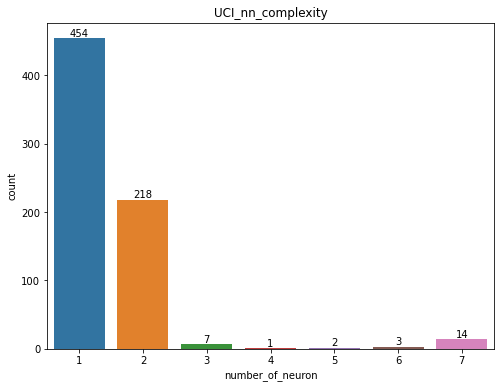

In [ ]:
# visuazlie the current result
data_for_visualize = pd.read_excel(file_name, sheet_name="UCI", header=None, names=["index", "y","number_of_neuron","correct_count"])
print(data_for_visualize)

plt.figure(figsize=(8,6))
ax = sns.countplot(x=data_for_visualize[value])
ax.bar_label(ax.containers[0])
ax.set_title('UCI_nn_complexity')